In [15]:
import torch
from torch import nn,optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
%matplotlib inline

# Device for Training

In [16]:
# Get cpu, gpu or mps device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Loading Data

In [17]:
force = False
training_data = datasets.MNIST('data',train=True,download=force,transform=ToTensor())
test_data = datasets.MNIST('data',train=False,transform=ToTensor())

train_dataloader = DataLoader(training_data,batch_size=100)
test_dataloader = DataLoader(test_data,batch_size=100)

def print_shape(dataloader):
    X,y = next(iter(dataloader))
    print(f"Steps_per_epoch = {len(dataloader)}\n"
          f"Shape of X [N, C, H, W]: {X.shape}\n"
          f"Shape of y: {y.shape} {y.dtype}")
print_shape(train_dataloader)
print_shape(test_dataloader)

Steps_per_epoch = 600
Shape of X [N, C, H, W]: torch.Size([100, 1, 28, 28])
Shape of y: torch.Size([100]) torch.int64
Steps_per_epoch = 100
Shape of X [N, C, H, W]: torch.Size([100, 1, 28, 28])
Shape of y: torch.Size([100]) torch.int64


# Add noise

In [18]:
def visualize_rows(*rows,n=20):
    fig,axs = plt.subplots(len(rows),n,
                           figsize=(n,len(rows)))
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
    for ax_r,row in zip(axs,rows):
        for ax, img in zip(ax_r,row):
            ax.imshow(img,cmap='gray')
    plt.show()

In [19]:
def noising(X, noise_factor = 0.2):
    return torch.randn_like(X)*noise_factor + X

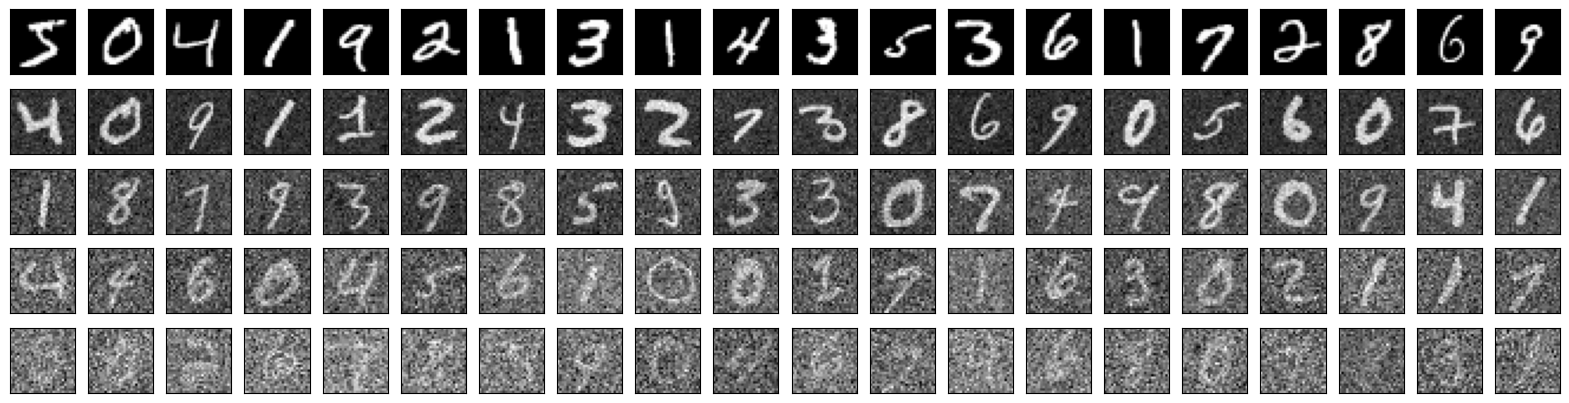

In [20]:
def fn():
    X,_ = next(iter(train_dataloader))
    X = X.reshape(5,-1,28,28)
    for i,k in enumerate([0,0.1,0.2,0.4,0.8]):
        X[i,:] = noising(X[i,:],noise_factor=k)
    visualize_rows(*X,n=X.size(1))
fn()

# Model Development

In [21]:
from torch import nn

class MNIST_Encoder(nn.Module):
    def __init__(self,output_size) -> None:
        super(MNIST_Encoder,self).__init__()
        self.output_size = output_size
        self.conv = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=3),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            
            nn.Conv2d(12, 24, kernel_size=6, stride=2),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            
            nn.Conv2d(24, 32, kernel_size=6, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Flatten(),
        )
        
        self.encoder = nn.Sequential(
            nn.Linear(288, 100, bias=False),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, output_size, bias=False),
            nn.BatchNorm1d(output_size),
            nn.ReLU(),
        )
        
    def forward(self,x):
        x = self.conv(x)
        x = self.encoder(x)
        return x

class MNIST_Decoder(nn.Module):
    def __init__(self,input_size,ngf=64,channel_num=1) -> None:
        self.input_size =  input_size
        super(MNIST_Decoder,self).__init__()
        # number of generator filters
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(input_size, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2,ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf,channel_num, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )
    
    def forward(self,x):
        x = x.view(x.size(0),-1,1,1)
        return self.decoder(x)

class Autoencoder(nn.Module):
    def __init__(self, encoder,decoder) -> None:
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def encode(self,x):
        return self.encoder(x)
    def decode(self,x):
        return self.decoder(x)
    def forward(self,x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [22]:
model = Autoencoder(MNIST_Encoder(10),MNIST_Decoder(10)).to(device)
model.load_state_dict(torch.load("model_checkpoint/mnist_autoencoder.pth"))
X,_ = next(iter(train_dataloader))
model(X.to(device)).shape

torch.Size([100, 1, 28, 28])

# Develop Optimization Iteration

In [23]:
# optimization configurations
loss_fn = nn.CrossEntropyLoss()
epochs = 1
max_learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr = max_learning_rate,
                                          steps_per_epoch=len(train_dataloader),
                                          epochs=epochs,)

In [24]:
def train(train_dataloader, model, loss_fn, optimizer,scheduler):
    model.train()
    train_loss = 0
    for X,y in train_dataloader:
        X = X.to(device)
        
        # Forward pass
        pred = model(noising(X))
        loss = loss_fn(pred.view(pred.size(0),-1), X.view(X.size(0),-1))
        
        # trace
        train_loss += loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    num_batches = len(train_dataloader)
    train_loss /= num_batches
    return train_loss

In [25]:
def test(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(device)
            
            # forward pass
            pred = model(noising(X))
            loss = loss_fn(pred.view(pred.size(0),-1), X.view(X.size(0),-1))
            test_loss += loss.item()
    
    num_batches = len(dataloader)
    test_loss /= num_batches
    return test_loss

In [26]:
def compress_n_plot(model,X):
    model.eval()
    with torch.no_grad():
        noise_X = noising(X,0.5)
        
        decoded = model(noise_X.to(device))
        decoded = decoded.to('cpu')
        
        # to_img = lambda flat: flat.view(flat.size(0),28,28))
        X = X.view(X.size(0),28,28)
        noise_X = noise_X.view(noise_X.size(0),28,28)
        decoded = decoded.view(decoded.size(0),28,28)
        
        visualize_rows(X,noise_X,decoded)
        plt.show()
    
def plot_loss(train_losses,test_losses):
    plt.title(f"Epoch - {len(train_losses)}")
    plt.plot(train_losses,label="train loss")
    plt.plot(test_losses,label="test loss")
    plt.legend()
    plt.show()

# Run the iteration

In [13]:
train_losses = []
test_losses = []

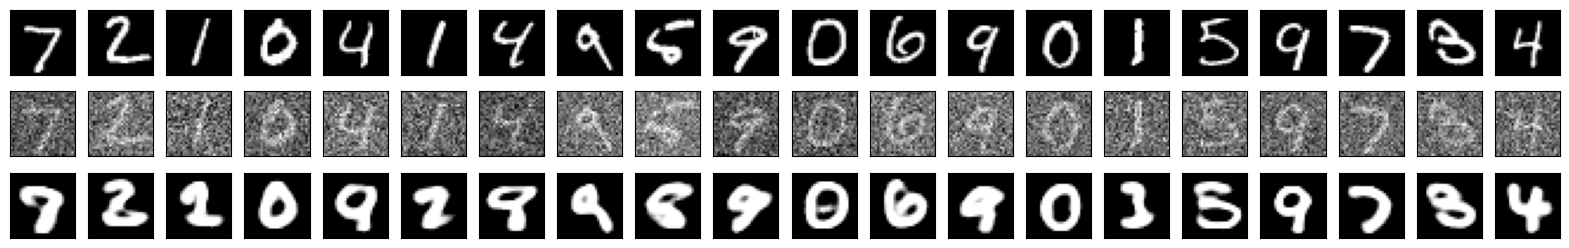

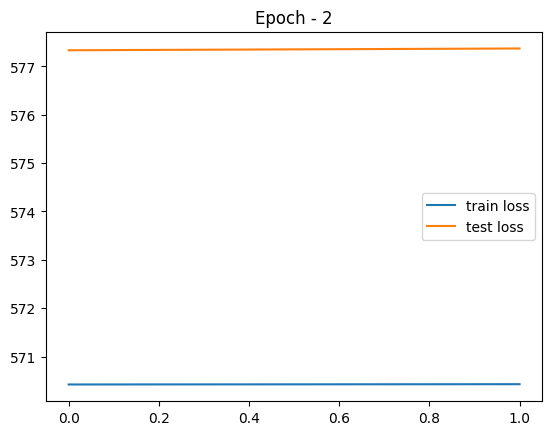

Done!


In [29]:
def fn():
    from IPython.display import clear_output
    for _ in range(epochs):

        train_loss = train(train_dataloader,model, loss_fn, optimizer,scheduler)
        test_loss  = test(test_dataloader,model,loss_fn)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        with torch.no_grad():
            X,y = next(iter(test_dataloader))
            clear_output()
            compress_n_plot(model,X)
            plot_loss(train_losses,test_losses)
            
        
    print("Done!")
fn()

In [30]:
# torch.save(model.state_dict(), "model_checkpoint/mnist_autoencoder.pth")
model = Autoencoder(MNIST_Encoder(10),MNIST_Decoder(10))
model.load_state_dict(torch.load("model_checkpoint/mnist_autoencoder.pth"))
model.to(device);

# Example Usage

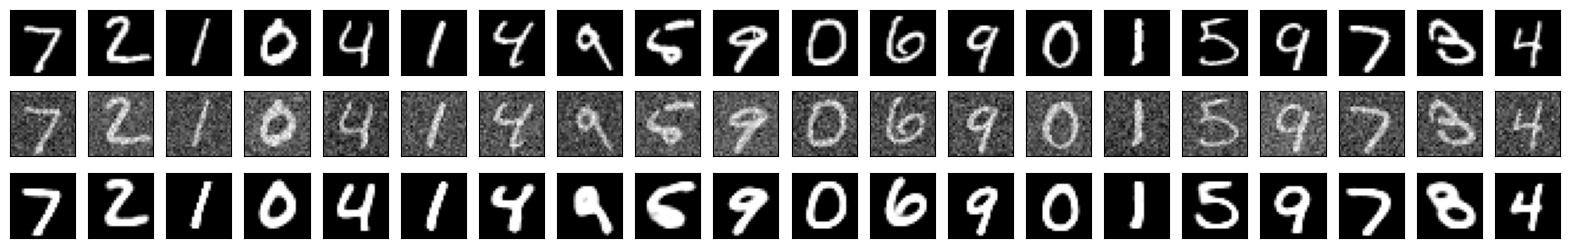

In [31]:
with torch.no_grad():
    X,_ = next(iter(test_dataloader))
    noise_X = noising(X,0.2)
    
    code = model.encode(noise_X.to(device))
    decoded = model.decode(code).to('cpu')
    
    noise_X = noise_X.view(noise_X.size(0),28,28)
    X = X.view(X.size(0),28,28)
    decoded = decoded.view(X.size(0),28,28)
    
    visualize_rows(X,noise_X,decoded)

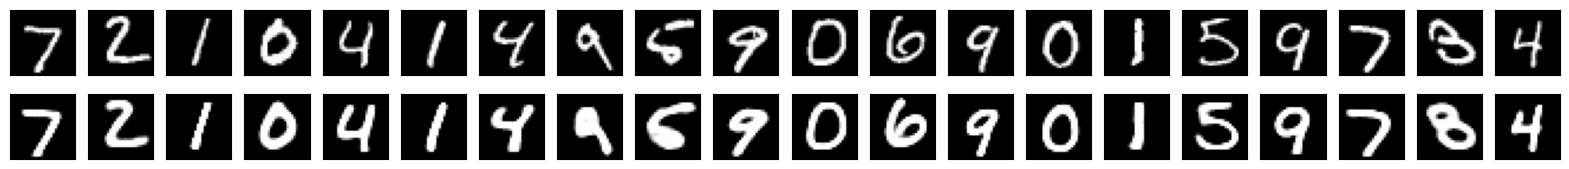

In [32]:
with torch.no_grad():
    X,_ = next(iter(test_dataloader))

    code = model.encode(X.to(device))
    
    decoded = model.decode(code).to('cpu')
    X = X.view(X.size(0),28,28)
    decoded = decoded.view(X.size(0),28,28)
    
    visualize_rows(X,decoded)